# WAVENET

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
words = open('Data\\names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [24]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [2]:

# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    
    if self.training:
      if x.ndim ==3:
        dim = (0,1)
      elif x.ndim ==2:
        dim  = 0
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
class Embedding:

  def __init__(self, num_embedding, embedding_dim):
    self.weight = torch.randn(num_embedding, embedding_dim)
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

  #define constructor at 32:06
  def __init__(self, n):
    # we are defining how many consecutive characters we want to concatenate in the last dimesninon of the output
    self.n = n 

  def __call__(self, x):
    #pop out the shape of the input to flatter
    #batch, time, channels (4,8,10)
    B,T,C = x.shape
    # x = x.view(B, -1, C*n)
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x =x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


class Sequential:

  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    p = [] 
    for layer in self.layers:
      for par in layer.parameters():
        p.append(par)
    return p

### Flatten Consecutive Development

In [42]:
#Taking the model intermediate answer and seeing the shapes. 
ix = torch.randint(0, Xtr.shape[0], (4,))

t = Xtr[ix]
logits = model(t)
t

tensor([[ 0,  0,  4,  5, 19,  5, 18,  1],
        [ 0,  0,  0,  4,  5, 25, 12,  9],
        [ 0,  0,  0,  0,  0, 11,  8,  1],
        [ 0,  0,  0,  0,  0,  0, 19, 21]])

In [67]:
#checking the indexing operation of python list, which is similar to the 
#one in pytorch tensors, particualrly the :: notation. 
rr = list(range(10))
rr[::8]

[0, 8]

In [86]:
# checking if the explicit concat is matching the one with the view operation
e = torch.randn(4,8,10)
explicit=  torch.cat((e[:,::2,:], e[:,1::2,:]), dim=2)
e = e.view(4,4,20)
(e == explicit).all() #do all because all elementwise operation

tensor(True)

In [103]:
#example of taking the spurious dimension out from the FlattenConsecutive layer. 
flat = FlattenConsecutive(8)
e = torch.randn(4,8,10)
e = flat(e)
e.shape

torch.Size([4, 80])

\Flatten Consecutive Over

In [7]:
## DEFINING THE MODEL

torch.manual_seed(42)
n_embd = 24
n_hidden=128
vocab_size = 27

C= torch.randn(vocab_size, n_embd)
model = Sequential([Embedding(vocab_size, n_embd),
          FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False ), BatchNorm1d(n_hidden), Tanh(),
          FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False ), BatchNorm1d(n_hidden), Tanh(),
          FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False ), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)])


parameters= model.parameters() #now the parameters are accessible fromt the model sequential class
print(sum(p.nelement() for p in parameters)) # number of parameters in total

with torch.no_grad():
    model.layers[-1].weight*=0.1


for p in parameters:
    p.requires_grad= True

with torch.no_grad():
    Xsample = Xtr[torch.randint(0, Xtr.shape[0], (32,))]
    print(Xsample.shape)
    model(Xsample)
    for layer in model.layers:
        print(layer.__class__.__name__, ':', tuple(layer.out.shape))


76579
torch.Size([32, 8])
Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


### Fixing batchnorm bug

In [149]:
model.layers[2].out.mean(0, keepdim=True).shape
#this is not the right size. We need it to be (1,1,200) 

torch.Size([1, 4, 200])

In [150]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 200])

\Fixing batchnorm Bug

In [8]:
max_steps =200000
# max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]
    logits = model(Xb)

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits, Yb)
    loss.backward()
    
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad
    lossi.append(loss.log10().item())
    # print('hey')
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')



      0/ 200000: 3.3196
  10000/ 200000: 2.1732
  20000/ 200000: 2.0698
  30000/ 200000: 2.0365
  40000/ 200000: 2.2763
  50000/ 200000: 2.2719
  60000/ 200000: 1.6087
  70000/ 200000: 1.4979
  80000/ 200000: 1.9430
  90000/ 200000: 1.9322
 100000/ 200000: 1.9473
 110000/ 200000: 1.7607
 120000/ 200000: 1.5525
 130000/ 200000: 1.7896
 140000/ 200000: 1.4473
 150000/ 200000: 1.8200
 160000/ 200000: 1.7864
 170000/ 200000: 2.1441
 180000/ 200000: 1.8534
 190000/ 200000: 1.9454


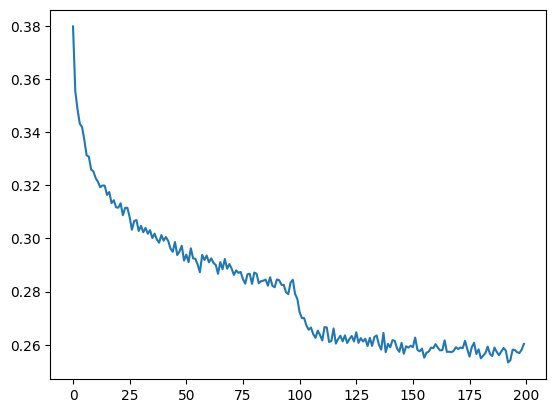

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [10]:
for layer in model.layers:
    layer.training = False

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # emb = C[x] # (N, block_size, n_embd)
  # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  # for layer in layers:
  #   x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7862582206726074
val 1.989817500114441


In [63]:
# torch.manual_seed(42)

# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        pass
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

KeyboardInterrupt: 

In [17]:
context  = [0] * block_size
torch.tensor([context]).shape

torch.Size([1, 8])

In [9]:
model(torch.tensor([context]))

tensor([[ 0.1575, -0.1134,  0.0426,  0.0673, -0.0091,  0.0395, -0.0221,  0.0365,
         -0.0268, -0.0013, -0.0232, -0.0043, -0.0516, -0.0249,  0.1244, -0.0301,
         -0.1170, -0.0331, -0.0196, -0.0647,  0.0537,  0.0322,  0.0337, -0.0102,
         -0.0716, -0.0129,  0.0376]], grad_fn=<AddBackward0>)

In [58]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [87]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [88]:
for i in range (8):
    probs = F.softmax(logits[i])
    # sample from the distribution
    # ix = torch.multinomial(probs, num_samples=1).item()
    a,b = probs.max(dim=0)
    print(itos[b.item()])

a
a
a
n
n
r
e
.


C:\Users\Z004V3HN\AppData\Local\Temp\ipykernel_22904\2524347869.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits[i])


In [85]:
a, b = probs.max(dim=0)
b.item()

0

In [66]:
logits.shape

torch.Size([1, 27])

In [28]:
xx = torch.tensor([context])
C[xx].shape
xx.shape

torch.Size([1, 3])